In [8]:
import numpy as np
import os
# from typing import defaultdict
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from SGYReader import SGYReader
# import cv2
import re
from numpy.fft import rfft, irfft

# Convergence check

In [13]:
class ConvergenceCheck:
    # def __init__(self, path: str, prefix: str, cases_dict: dict[int, int], error_size: int=10000, verbose: bool=False):
    def __init__(self, path, prefix, cases_dict, error_size=10000, verbose=False):
        # self.tensors_list = defaultdict(dict)
        self.tensors_list = {}
        
        self.path = path
        self.prefix = prefix
        self.cases_dict = cases_dict

        for size_block in self.cases_dict:
            self.tensors_list[size_block] = {}
            for order in self.cases_dict[size_block]:
                reader = SGYReader()
                try:
                    self.tensors_list[size_block][order] = reader.read_segy(os.path.join(self.path), exp=f'{prefix}_{size_block}_{order}')
                    self.tensors_list[size_block][order] = { key: value[::-1, :] for key, value in self.tensors_list[size_block][order].items() }
                except FileNotFoundError:
                    print(f"Not found {size_block} {order}")

        # self.x_ax = defaultdict(dict)
        # self.time_evaluation = defaultdict(dict)
        self.x_ax = {}
        self.time_evaluation = {}
        self.verbose = verbose

        for size_block in self.cases_dict:
            self.x_ax[size_block] = {}
            self.time_evaluation[size_block] = {}
            for order in self.cases_dict[size_block]:
                try:
                    with open(os.path.join(self.path, f'{prefix}_{size_block}_{order}', 'output', 'userlog.txt')) as f:
                        log = f.read().split('\n')
                        if verbose:
                            print(f"{size_block}_{order} uploaded")
                except FileNotFoundError:
                    if verbose:
                        print(f"{size_block}_{order} not uploaded")
                    self.x_ax[size_block][order] = np.arange(1, error_size + 1) * 1.0 / error_size
                    continue

                for line in log:
                    match = re.search(r"Time step ([\d.eE+-]+)", line)
                    if match:
                        step = float(match.group(1)[:-1])
                        len = list(self.tensors_list[size_block][order].values())[0].shape[-1]
                        self.x_ax[size_block][order] = np.arange(1, len + 1) * step
                        print(f"Найдена величина шага по времени {size_block} {order}: {step}")
                        break
                
                for line in log:
                    match = re.search(r"Calculation time is: ([\d.eE+-]+)", line)
                    if match:
                        self.time_evaluation[size_block][order] = int(match.group(1))
                        print(f"Найдено время работы солвера для {size_block} {order}: {self.time_evaluation[size_block][order]}")
                        break
                if verbose:
                    print('-' * 20)

    # def plot(self, sizes_block: list[int], receivers: list[int], orders: list[int]):
    def plot(self, sizes_block, receivers, orders):
        fig, axs = plt.subplots(3, 2, figsize=(16, 12))

        for ind_variable, var in enumerate(['ux', 'uy', 'vx', 'vy', 'ax', 'ay']):
            for ind_reciever, size_block in enumerate(sizes_block): 
                for order in orders:
                # for order in [7, 8, 9]:
                    axs[ind_variable // 2][ind_variable % 2].plot(
                        self.x_ax[size_block][order], 
                        self.tensors_list[size_block][order][ind_variable, receivers[ind_reciever]], 
                        label=f'{size_block} {order} {size_block * receivers[ind_reciever]}'
                    )
                axs[ind_variable // 2][ind_variable % 2].set_title(f"Size block: {size_block}, variable: {var}")
                axs[ind_variable // 2][ind_variable % 2].legend()

    # def error(self, size_block: int, order_1: int, order_2: int, recievers: list[int]):
    def error(self, size_block, order_1, order_2, recievers):
        # errors = defaultdict(dict)
        errors = {}
        errors[size_block] = {}
        for var in ['u_x', 'u_y', 'v_x', 'v_y', 'a_x', 'a_y']:
            errors[size_block][var] = []

        for reciever in recievers:
            t_a = self.x_ax[size_block][order_1]
            t_b = self.x_ax[size_block][order_2]
            
            print(t_a.shape, t_a[-1])
            print(t_b.shape, t_b[-1])
            for ind, var in enumerate(['u_x', 'u_y', 'v_x', 'v_y', 'a_x', 'a_y']):
                a = self.tensors_list[size_block][order_1][ind, reciever]
                b = self.tensors_list[size_block][order_2][ind, reciever]

                a_interp = np.interp(t_b, t_a, a)
                errors[size_block][var].append(
                    np.max(np.abs(b - a_interp)) / np.max([np.max(np.abs(b)), np.max(np.abs(a_interp))]) * 100
                )
                print(f"error {var}: {errors[size_block][var][-1]:.2f} || delta: {np.max(np.abs(b - a_interp)):.2e} || {np.max([np.max(np.abs(b)), np.max(np.abs(a_interp))]):.2e}")
                # print(t_b[np.argmax(np.abs(b - a_interp))])
            print('-'*20)
        return errors

In [14]:
conv_5freq = ConvergenceCheck(
    path=os.path.join('..', '..', 'exps', 'Layers5', 'Convergence_5freq'),
    prefix="lamb_40_80_120_160",
    cases_dict= { key: [7, 9] for key in [10, 15, 20, 25, 30, 40, 50] },
    verbose = True
)

10_7 uploaded
Найдена величина шага по времени 10 7: 0.000163425873
Найдено время работы солвера для 10 7: 6755
--------------------
10_9 uploaded
Найдена величина шага по времени 10 9: 0.000102528119
Найдено время работы солвера для 10 9: 8997
--------------------
15_7 uploaded
Найдена величина шага по времени 15 7: 0.000231338962
Найдено время работы солвера для 15 7: 4826
--------------------
15_9 uploaded
Найдена величина шага по времени 15 9: 0.0001451346
Найдено время работы солвера для 15 9: 5947
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000326851746
Найдено время работы солвера для 20 7: 2509
--------------------
20_9 uploaded
Найдена величина шага по времени 20 9: 0.000205056238
Найдено время работы солвера для 20 9: 4654
--------------------
25_7 uploaded


IndexError: list index out of range

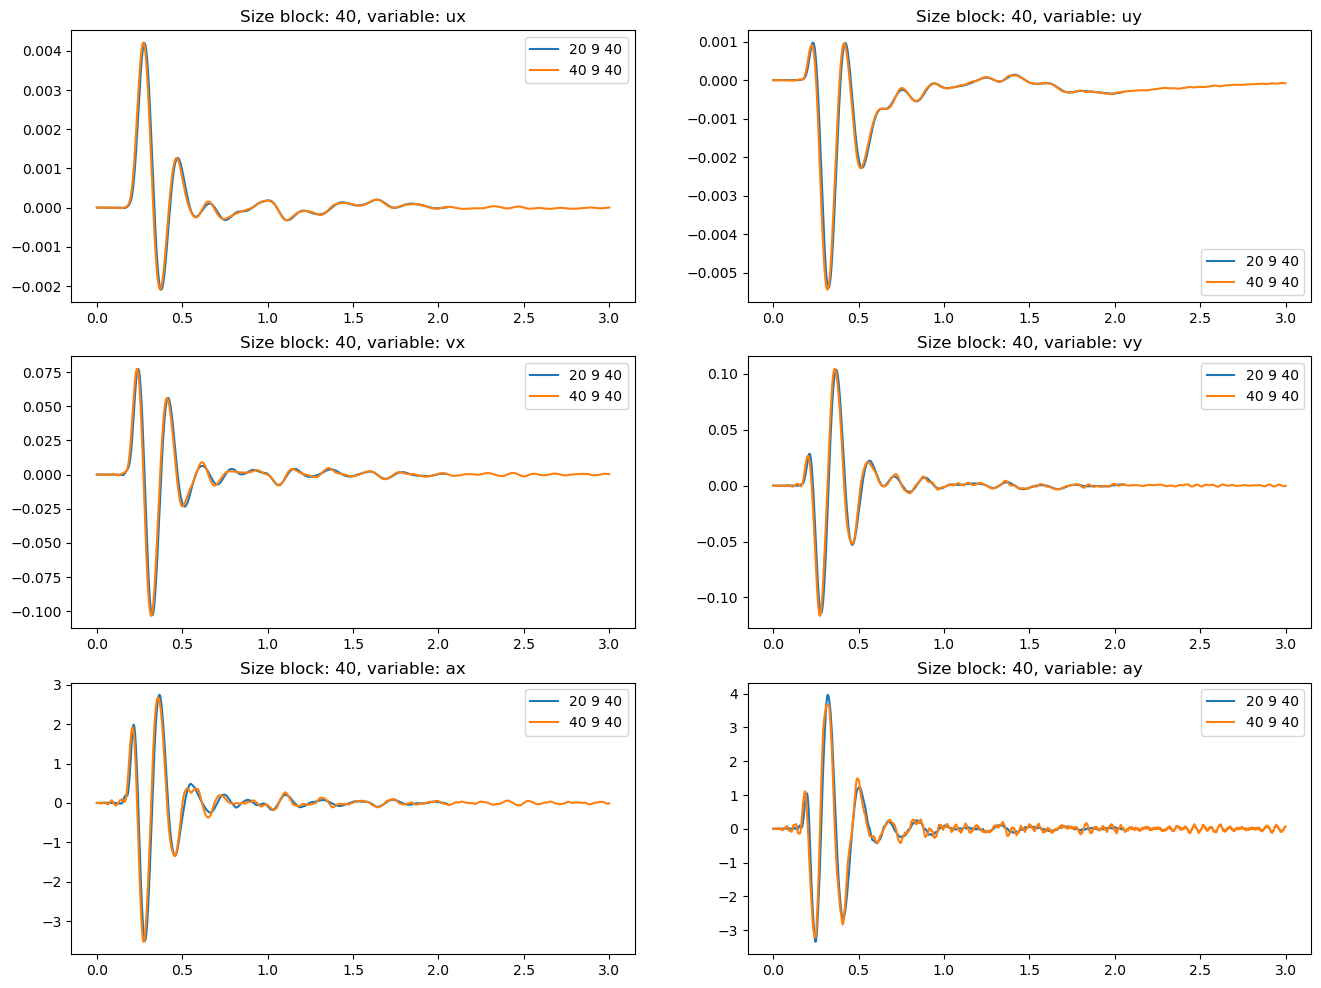

In [4]:
conv_5freq.plot([20, 40], [2, 1], [9])

In [5]:
size_block = 25
errors = conv_5freq.error(size_block, 7, 9, np.arange(1, conv_5freq.tensors_list[size_block][7].shape[1]))

for var in errors[size_block]:
    print(f"{var}: {np.mean(errors[size_block][var]):.2f} +- {np.std(errors[size_block][var]):.2f} %")

(8312,) 3.0001945477520002
(10000,) 2.26446732
error u_x: 0.35 || delta: 1.51e-05 || 4.31e-03
error u_y: 0.44 || delta: 2.71e-05 || 6.09e-03
error v_x: 0.61 || delta: 6.46e-04 || 1.06e-01
error v_y: 1.65 || delta: 1.90e-03 || 1.15e-01
error a_x: 2.09 || delta: 7.65e-02 || 3.65e+00
error a_y: 5.74 || delta: 2.31e-01 || 4.02e+00
--------------------
(8312,) 3.0001945477520002
(10000,) 2.26446732
error u_x: 0.43 || delta: 1.73e-05 || 4.05e-03
error u_y: 0.52 || delta: 2.58e-05 || 4.92e-03
error v_x: 1.09 || delta: 1.11e-03 || 1.02e-01
error v_y: 1.61 || delta: 1.83e-03 || 1.13e-01
error a_x: 2.06 || delta: 7.03e-02 || 3.41e+00
error a_y: 5.75 || delta: 2.25e-01 || 3.92e+00
--------------------
(8312,) 3.0001945477520002
(10000,) 2.26446732
error u_x: 0.65 || delta: 2.10e-05 || 3.22e-03
error u_y: 0.63 || delta: 2.53e-05 || 4.04e-03
error v_x: 1.57 || delta: 1.32e-03 || 8.40e-02
error v_y: 1.50 || delta: 1.69e-03 || 1.12e-01
error a_x: 2.91 || delta: 8.52e-02 || 2.92e+00
error a_y: 6.01 ||

In [6]:
conv_5freq.time_evaluation[size_block][9] / 3600 

0.2811111111111111

# Demphing Analysis

In [9]:
E = 8732900000
nu = 0.25
rho = 1000
L = 500

In [10]:
v_p = np.sqrt(E * (1 - nu) / (1 + nu) / (1 - 2 * nu) / rho)
v_s = np.sqrt(E / 2 / (1 + nu) / rho)
v_r = (0.862 + 1.14 * nu) / (1 + nu) * v_s
print(f"Скорость продольной волны: {v_p}")
print(f"Скорость поперечной волны: {v_s}")
print(f"Скорость Рэлеевской волны: {v_r}") 

Скорость продольной волны: 3237.2024959832215
Скорость поперечной волны: 1868.9997324772414
Скорость Рэлеевской волны: 1714.9941545211166


In [236]:
def demphing_analysis(size_block: int, order: int, variable: int, epsilon_order: float, T: float, convergence_object: ConvergenceCheck, E: float, nu: float, rho: float, L: float, x_0: float=1, x_1: float=3):
    v_p = np.sqrt(E * (1 - nu) / (1 + nu) / (1 - 2 * nu) / rho)
    print(f"Скорость продольной волны: {v_p}")
    v_s = np.sqrt(E / 2 / (1 + nu) / rho)
    print(f"Скорость поперечной волны: {v_s}")
    v_r = (0.862 + 1.14 * nu) / (1 + nu) * v_s
    print(f"Скорость Рэлеевской волны: {v_r}")

    times = convergence_object.x_ax[size_block][order]
    print(f"Временной шаг: {times[1] - times[0]}")

    tensor = convergence_object.tensors_list[size_block][order][variable]
    print(f"Размерность тензора: {tensor.shape}")

    eps = np.abs(tensor[-1, :]).max() * epsilon_order
    print(f"Величина ошибки: {eps:.2e}")

    ind_wave = np.argmax(np.abs(tensor[-1, :]) > eps) 
    print(f"Индекс прихода волны: {ind_wave}")

    time_wave = ind_wave / tensor.shape[-1] * T
    print(f"Время прихода волны: {time_wave:.2f} с")

    v_p_exp = L / time_wave
    print(f"Скорость пришедшей волны: {v_p_exp:.2f} м/с")

    print('-'*20)

    t_intersection = 2 * L / (v_p_exp + v_s)
    print(f"Время пересечения волн: {t_intersection:.2f} с")

    ind_intersection = np.argmin(np.abs(times - t_intersection))
    print(f"Индекс пересечения волн: {ind_intersection}")

    x_intersection = t_intersection * v_s
    print(f"Расстояние пересечения: {x_intersection:.2f} м")

    reciever_intersection = np.argmin(np.abs(
        np.array([size_block * i for i in range(tensor.shape[0])]) - x_intersection)
    )
    print(f"Номер приемника, ближайшего к пересечению: {reciever_intersection}")

    print('-'*20)

    print(f"Время прихода падающей волны через ресивер пересечения: {reciever_intersection * size_block / v_p_exp:.2f} с")

    ind_intersection_wave = np.argmin(np.abs(times - reciever_intersection * size_block / v_p_exp))
    print(f"Индекс прихода падающей волны через ресивер пересечения: {ind_intersection_wave}")

    reflection_wave_amplitude = np.abs(tensor[reciever_intersection:-1, ind_wave:ind_intersection]).max()
    print(f"Максимальная амплитуда отраженной волны: {reflection_wave_amplitude}")

    falling_wave_amplitude = np.abs(tensor[reciever_intersection:-1, ind_intersection_wave:ind_wave]).max()
    print(f"Максимальная амплитуда падающей волны: {falling_wave_amplitude}")

    print(f"Отношение амплитуд падающей и отраженной волны: {100 * falling_wave_amplitude / reflection_wave_amplitude:.2f}%")

    print('-'*20)
    recievers_number = tensor.shape[0]
    for reciever in range(reciever_intersection, recievers_number-1, 1):
        try:
            print(f"{reciever * size_block / v_p_exp:.2f}:{t_intersection:.2f} с")
            amplitude_max = np.abs(
                tensor[reciever, np.argmin(np.abs(times - reciever * size_block / v_p_exp)):ind_intersection]
            ).max()
            print(f"{(2 * L - reciever * size_block) / v_p_exp:.2f}:{t_intersection:.2f} с")
            amplitude_reflection = np.abs(
                tensor[reciever, np.argmin(np.abs(times - (2 * L - reciever * size_block) / v_p_exp)):ind_intersection]).max()
            
            print(f"{reciever}: Отношение амплитуд падающей и отраженной волны: {100 * amplitude_reflection / amplitude_max:.2f}%")
        except:
            if reciever == reciever_intersection:
                print(f"{reciever}: Продольная волна пересекласлась с поперечной")
            else:
                print(f"{reciever}: проблема с расчетом")
        
        print('-'*4)

    print('-'*20)

    a = np.abs(tensor[reciever_intersection:-1, np.argmin(np.abs(times - reciever_intersection * size_block / v_p_exp)):ind_wave]).max()
    b = np.abs(tensor[reciever_intersection:-1, ind_wave:ind_intersection]).max()
    print(f"Отношение амплитуд падающей и отраженной волны: {100 * b / a:.2f}%")

    print('-'*20)


    plt.figure(figsize=(18, 10))
    for reciever in range(reciever_intersection, recievers_number, 1):
        plt.plot(times, tensor[reciever, :], label=f"{reciever * size_block}")
        # plt.semilogy(times, np.abs(tensor[reciever, :]), label=f"{reciever * size_block}")
        print(f"{reciever * size_block}: {reciever * size_block / v_p_exp} {(2*L - reciever * size_block) / v_p_exp}")
        plt.axvline(x=reciever * size_block / v_p_exp, color='green', linestyle='--')
        plt.axvline(x=(2*L - reciever * size_block) / v_p_exp, color='blue', linestyle='--')


    # plt.xlim(0, t_intersection)
    plt.axvline(x=t_intersection, color='red', linestyle='--')
    plt.axvline(x=time_wave, color='black', linestyle='--')
    plt.xlim(x_0, x_1)
    plt.legend()

In [237]:
demphire = ConvergenceCheck(
    path=os.path.join('..', '..', 'exps', 'Lamb_demphire'),
    prefix="lamb_demphire_R_0",
    cases_dict= { key: [7] for key in [20] },
    verbose = True
)

20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 975
--------------------


In [238]:
demphire.tensors_list[20][7].shape

(6, 27, 9103)

In [239]:
duplicate_index = []
for i in range(demphire.tensors_list[20][7].shape[1] - 1):
    s = np.abs(demphire.tensors_list[20][7][:, i] - demphire.tensors_list[20][7][:, i+1]).sum()
    if s < 1e-3 * demphire.tensors_list[20][7][:, i].max():
        print(i, s)
        duplicate_index.append(i)

cnt = 0
for i in duplicate_index:
    del_ind = i - cnt
    demphire.tensors_list[20][7][:, del_ind:-1] = demphire.tensors_list[20][7][:, del_ind+1:]
    demphire.tensors_list[20][7] = demphire.tensors_list[20][7][:, :-1]
    cnt += 1
print(demphire.tensors_list[20][7].shape)

20 0.0
(6, 26, 9103)


Скорость продольной волны: 376.431142253533
Скорость поперечной волны: 201.21090914638344
Скорость Рэлеевской волны: 186.35225739403512
Временной шаг: 0.000329563348
Размерность тензора: (26, 9103)
Величина ошибки: 3.94e-06
Индекс прихода волны: 4163
Время прихода волны: 1.37 с
Скорость пришедшей волны: 364.44 м/с
--------------------
Время пересечения волн: 1.77 с
Индекс пересечения волн: 5363
Расстояние пересечения: 355.72 м
Номер приемника, ближайшего к пересечению: 18
--------------------
Время прихода падающей волны через ресивер пересечения: 0.99 с
Индекс прихода падающей волны через ресивер пересечения: 2996
Максимальная амплитуда отраженной волны: 0.0002931528724730015
Максимальная амплитуда падающей волны: 0.0003571850247681141
Отношение амплитуд падающей и отраженной волны: 121.84%
--------------------
0.99:1.77 с
1.76:1.77 с
18: Отношение амплитуд падающей и отраженной волны: 20.69%
----
1.04:1.77 с
1.70:1.77 с
19: Отношение амплитуд падающей и отраженной волны: 19.73%
----


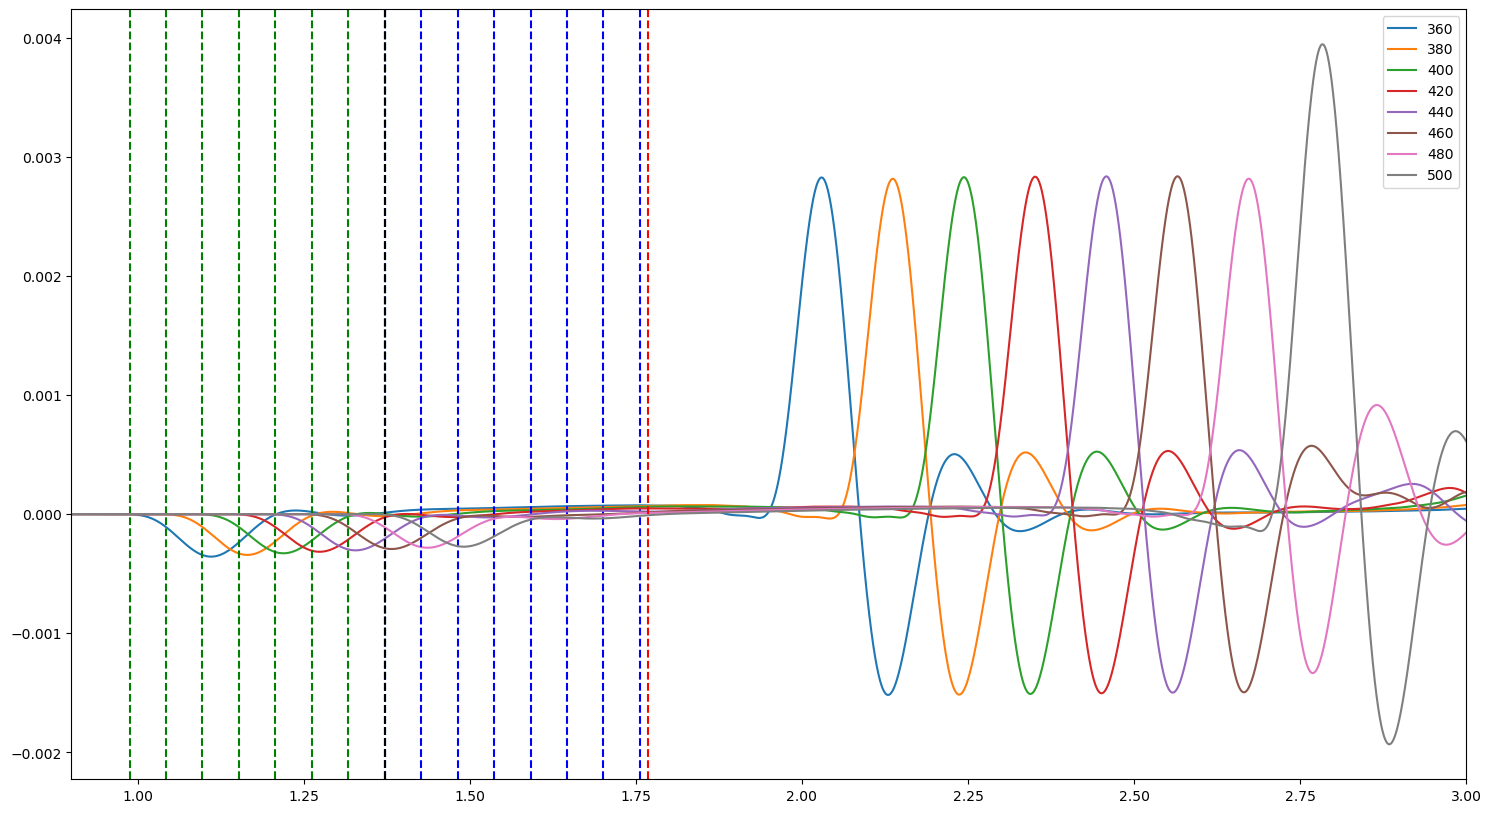

In [240]:
demphing_analysis(
    size_block=20,
    order=7,
    variable=0,
    epsilon_order=1e-3,
    T=3,
    convergence_object=demphire,
    E=2e+8,
    nu=0.3,
    rho=1900,
    L=500,
    x_0=0.9,
    x_1=3
)

## FFT

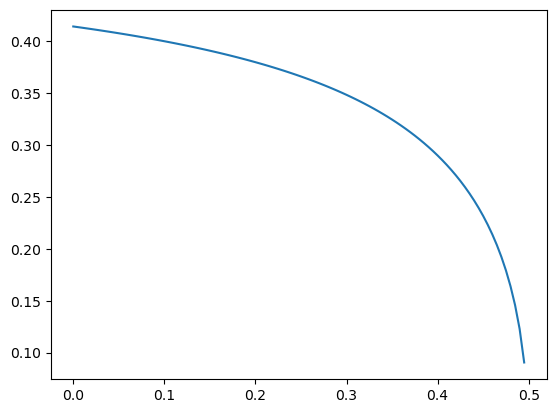

In [31]:
nu_values = np.arange(100) / 200
plt.plot(nu_values, 1 / (np.sqrt(1 + 1 / (1 - 2 * nu_values)) + 1), label="nu = 0.01")

In [179]:
def F(t, w):
    A = 1e+8
    w0 = 2 * np.pi * w
    w1 = w0 / np.sqrt(3)
    term_1 = A * w1**2 * np.exp(-w1 * t) / 4
    term_2 = np.sin(w0 * t) * (-t**2 / w1 + t / w1**2 + 1 / w1**3)
    term_3 = np.sqrt(3) * np.cos(w0 * t) * (t**2 / w1 + t / w1**2)

    return term_1 * (term_2 - term_3)

In [180]:
def fft_F(omega, w):
    A = 1e+8
    w0 = 2 * np.pi * w
    w1 = w0 / np.sqrt(3)
    
    beta_m = w1 + (omega - w0) * 1j
    beta_p = w1 + (omega + w0) * 1j

    term_1 = -w1 / 4j * (1 / beta_m**3 - 1 / beta_p**3)
    term_2 = 1 / 8j * (1 / beta_m**2 - 1 / beta_p**2)
    term_3 = 1 / (w1 * 8j) * (1 / beta_m - 1 / beta_p)

    term_4 = w1 / 4 * (1 / beta_m**3 + 1 / beta_p**3)
    term_5 = 1 / 8 * (1 / beta_m**2 + 1 / beta_p**2)

    return A * (term_1 + term_2 + term_3 - np.sqrt(3) * (term_4 + term_5)) / np.sqrt(2 * np.pi)

Text(0.5, 1.0, 'Cumsum of FFT Berlage')

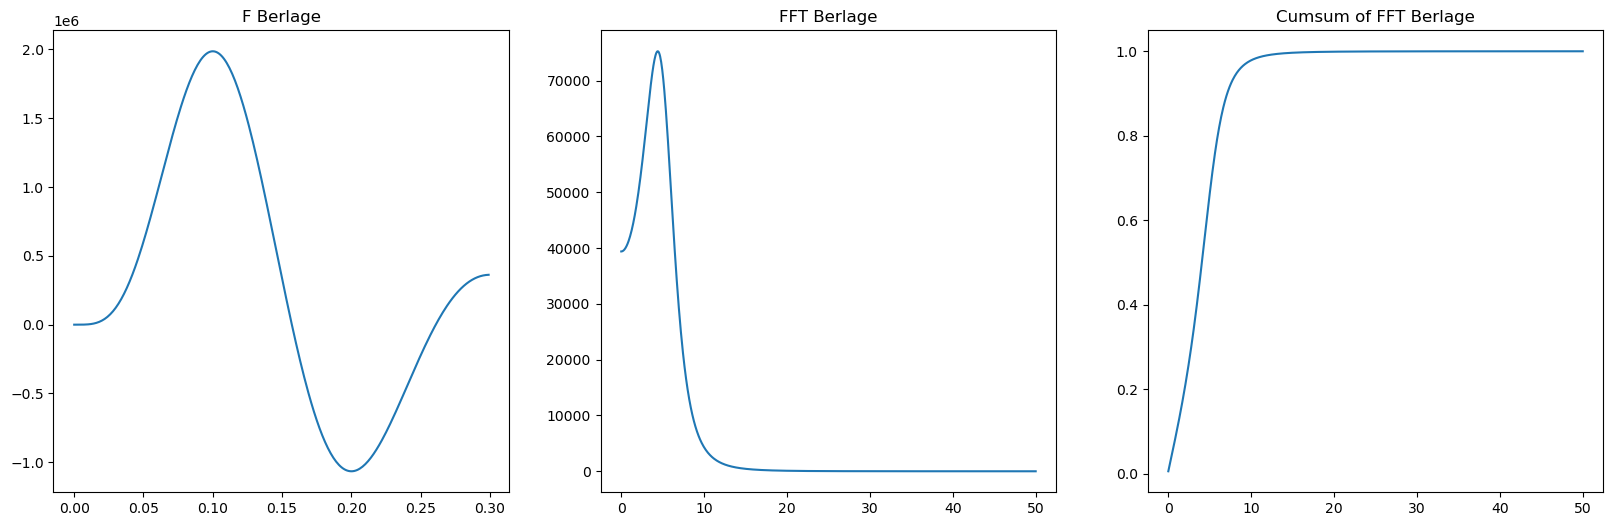

In [210]:
N = 300
w = 5

times = np.arange(N) / 1000
f_values = F(times, w)

freq_analytical = np.arange(800) / 16
omega_list = 2 * np.pi * freq_analytical
fft_analytical = fft_F(omega_list, w)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(times, f_values)
axs[0].set_title("F Berlage")
axs[1].plot(freq_analytical, np.abs(fft_analytical))
axs[1].set_title("FFT Berlage")
axs[2].plot(freq_analytical, np.abs(fft_analytical).cumsum() / np.abs(fft_analytical).sum())
axs[2].set_title("Cumsum of FFT Berlage")

In [237]:
fft_analytical = np.abs(fft_analytical)

energy = fft_analytical**2
cumsum = energy.cumsum() / energy.sum()
l = np.argmin(cumsum < 0.05)
r = np.argmax(cumsum > 0.95)
freq_analytical[l], freq_analytical[r], np.log2(freq_analytical[r] / freq_analytical[l])

(0.6875, 6.5, 3.241008099503795)

In [216]:
f_max = freq_analytical[np.argmax(np.abs(fft_analytical))]
f_aver = (freq_analytical * energy).sum() / energy.sum()
f_max, f_aver

(4.375, 3.8577713186935956)

In [217]:
v_p / f_max, v_p / f_aver, v_s / f_max , v_s / f_aver

(84.4055938143996, 95.72222986588281, 56.27039587626639, 63.81481991058854)

0.0 6.5


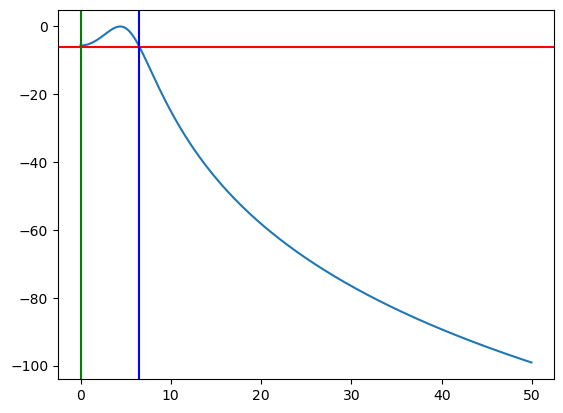

In [236]:
mag = 20*np.log10(fft_analytical/fft_analytical.max())
plt.plot(freq_analytical,mag)
f_lower, f_upper = freq_analytical[np.argmax(mag > -6)], freq_analytical[::-1][np.argmax(mag[::-1] > -6)]
print(f_lower, f_upper)
plt.axhline(y=-6, color='red')
plt.axvline(x=f_lower, color='green')
plt.axvline(x=f_upper, color='blue')

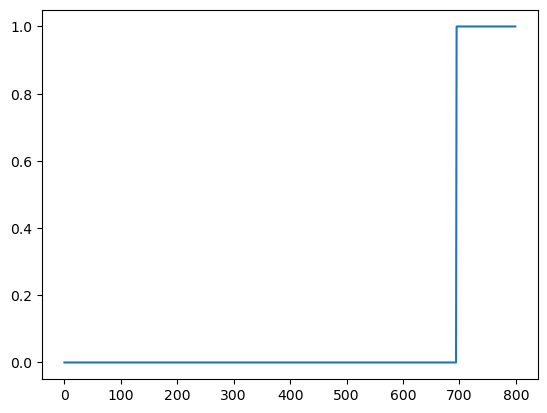

In [235]:
plt.plot(mag[::-1] > -6)

In [233]:
mag[np.argmax(mag[::-1] > -6)]

-92.96187010647613

In [226]:
mag

array([-5.62347149e+00, -5.62143586e+00, -5.61533038e+00, -5.60515937e+00,
       -5.59092999e+00, -5.57265234e+00, -5.55033944e+00, -5.52400725e+00,
       -5.49367480e+00, -5.45936415e+00, -5.42110051e+00, -5.37891232e+00,
       -5.33283129e+00, -5.28289255e+00, -5.22913469e+00, -5.17159995e+00,
       -5.11033428e+00, -5.04538751e+00, -4.97681349e+00, -4.90467026e+00,
       -4.82902020e+00, -4.74993025e+00, -4.66747205e+00, -4.58172221e+00,
       -4.49276251e+00, -4.40068011e+00, -4.30556784e+00, -4.20752442e+00,
       -4.10665478e+00, -4.00307030e+00, -3.89688913e+00, -3.78823649e+00,
       -3.67724498e+00, -3.56405494e+00, -3.44881474e+00, -3.33168114e+00,
       -3.21281961e+00, -3.09240471e+00, -2.97062039e+00, -2.84766036e+00,
       -2.72372837e+00, -2.59903855e+00, -2.47381570e+00, -2.34829556e+00,
       -2.22272503e+00, -2.09736239e+00, -1.97247743e+00, -1.84835160e+00,
       -1.72527802e+00, -1.60356148e+00, -1.48351831e+00, -1.36547624e+00,
       -1.24977409e+00, -

In [79]:
N = 3
v_p = 376.431142253533
table_n = 1
mult = 100000

R_c = 0.001
demphire_width = 100
b_0 = -(N + 1) * v_p * np.log(R_c)  / 2 / demphire_width
b_x = []
for x in range(0, 110, 10):
    b_x.append(mult * b_0 * (x / demphire_width)**N)
for i in range(len(b_x)):
    print(f"modify table {table_n} cell {i+1} {2} value {b_x[i]:.3f}")    

modify table 1 cell 1 2 value 0.000
modify table 1 cell 2 2 value 5200.588
modify table 1 cell 3 2 value 41604.707
modify table 1 cell 4 2 value 140415.887
modify table 1 cell 5 2 value 332837.659
modify table 1 cell 6 2 value 650073.553
modify table 1 cell 7 2 value 1123327.099
modify table 1 cell 8 2 value 1783801.828
modify table 1 cell 9 2 value 2662701.271
modify table 1 cell 10 2 value 3791228.958
modify table 1 cell 11 2 value 5200588.420


In [63]:
demphire.plot([25], [10], [9])

NameError: name 'demphire' is not defined

In [283]:
size_block = 25
order = 9
val = 0
T_exp = 2.95736835
times = demphire.x_ax[size_block][order]
tensor = demphire.tensors_list[size_block][order][val]
eps = np.abs(tensor[-1, :]).max() / 10000
print(f"Величина ошибки: {eps:.2e}")
ind_wave = np.argmax(np.abs(tensor[-1, :]) > eps) 
time_wave = ind_wave / tensor.shape[-1] * T_exp
v_p_exp = L / time_wave
print(f"Индекс прихода волны: {ind_wave}")
print(f"Время прихода волны: {time_wave:.2f} с")
print(f"Скорость пришедшей волны: {v_p_exp:.2f} м/с")

t_intersection = 2 * L / (v_p + v_s)
x_intersection = t_intersection * v_s
print(f"Время пересечения: {t_intersection:.2f} с")
print(f"Расстояние пересечения: {x_intersection:.2f} м")

Величина ошибки: 2.20e-07
Индекс прихода волны: 5021
Время прихода волны: 1.48 с
Скорость пришедшей волны: 336.72 м/с
Время пересечения: 1.62 с
Расстояние пересечения: 400.00 м


In [281]:
tensor.shape

(21, 10000)

400: 1.1879157188279998 1.7818735782419999
425: 1.26216045125475 1.7076288458152498
450: 1.3364051836814999 1.6333841133884999
475: 1.4106499161082497 1.5591393809617498
500: 1.4848946485349999 1.4848946485349999
525: 1.5591393809617498 1.4106499161082497


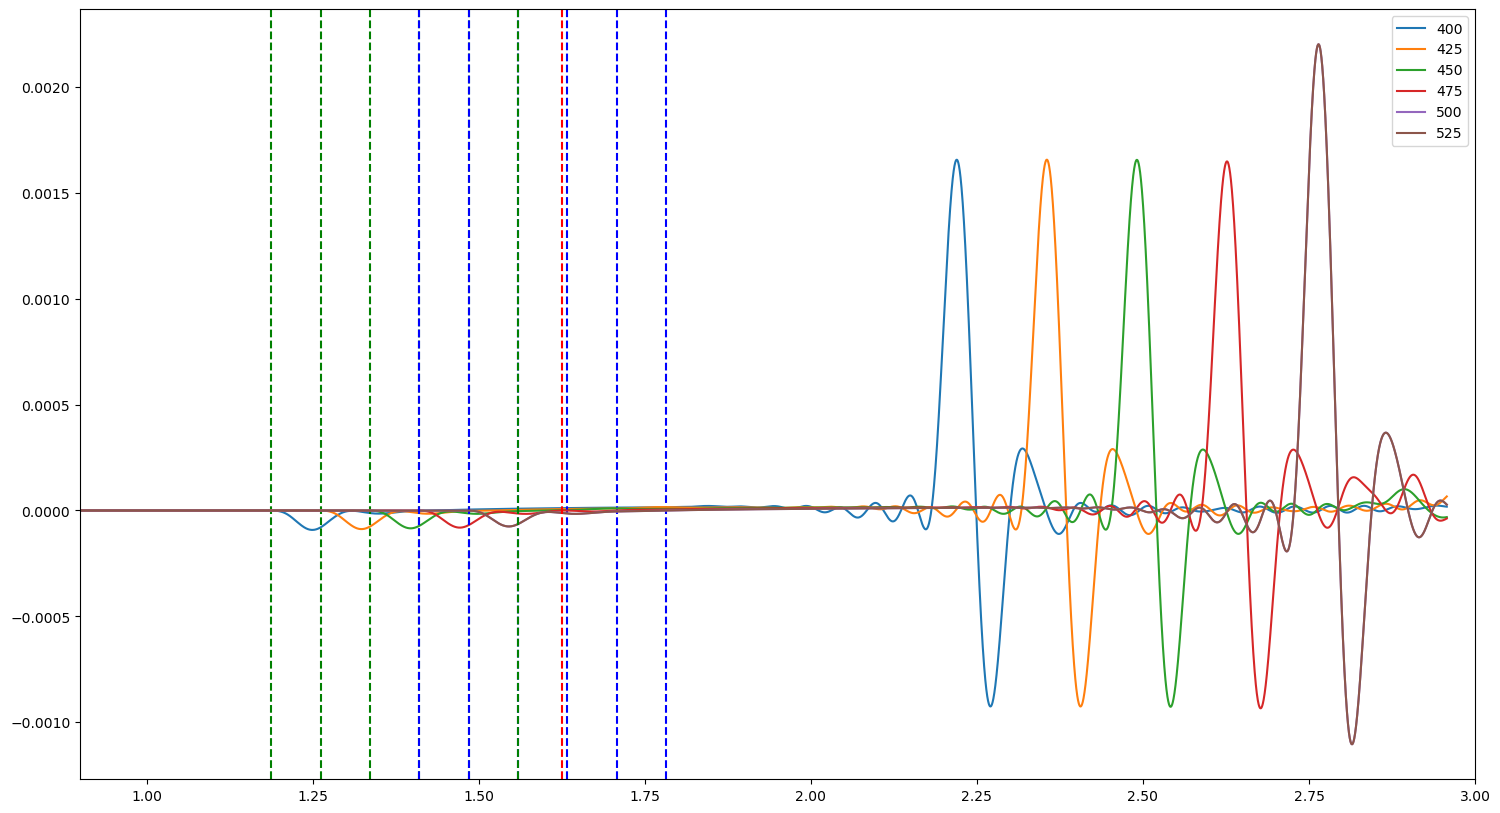

In [297]:
plt.figure(figsize=(18, 10))
recievers_number = tensor.shape[0]
for reciever in range(recievers_number-6, recievers_number, 1):
    plt.plot(times, tensor[reciever, :], label=f"{reciever * size_block}")
    print(f"{reciever * size_block}: {reciever * size_block / v_p_exp} {(2*L - reciever * size_block) / v_p_exp}")
    plt.axvline(x=reciever * size_block / v_p_exp, color='green', linestyle='--')
    plt.axvline(x=(2*L - reciever * size_block) / v_p_exp, color='blue', linestyle='--')
# plt.xlim(0, t_intersection)
plt.axvline(x=t_intersection, color='red', linestyle='--')
plt.xlim(0.9, 3)
plt.legend()

In [295]:
reciever = 16
print(f"Расстояние от источника до приемника: {reciever * size_block} м")
t_get = (reciever * size_block / v_p_exp)
ind_get = int(t_get / T_exp * tensor.shape[-1])
print(f"Время прихода волны: {t_get:.2f} с, индекс: {ind_get}")
t_ref = 2 * L / (v_p + v_s)
ind_ref = int(t_ref / T_exp * tensor.shape[-1])
print(f"Время падения волны: {t_ref:.2f} с, индекс: {ind_ref}")
tensor[reciever, int((reciever * size_block / v_p_exp) / T_exp * tensor.shape[-1])], int((reciever * size_block / v_p_exp) / T_exp * tensor.shape[-1])

Расстояние от источника до приемника: 400 м
Время прихода волны: 1.19 с, индекс: 4016
Время падения волны: 1.62 с, индекс: 5494


(-7.4229654e-09, 4016)

In [290]:
(reciever * size_block / v_p_exp)

1.1879157188279998

In [82]:
demphire_list = []
prefix_list = [
    'lamb_demphire_R_0_m_1',
    'lamb_demphire_R_000001_m_1',
    'lamb_demphire_R_000001_m_10',
    'lamb_demphire_R_000001_m_1000',
    'lamb_demphire_R_000001_m_100000',
    'lamb_demphire_R_001_m_1',
    'lamb_demphire_R_001_m_10',
    'lamb_demphire_R_001_m_1000',
    'lamb_demphire_R_001_m_100000',
]

for prefix in prefix_list:
    demphire_list.append(ConvergenceCheck(
        path=os.path.join('..', '..', 'exps', 'Lamb_demphire_mult'),
        prefix=prefix,
        cases_dict= { key: [7] for key in [20] },
        verbose = True
    ))
    # demphire.tensors_list[20][7].shape

20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4060
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4840
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4958
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 4865
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3301
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3019
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3899
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Н

In [83]:
for var in ['Ux', 'Uy', 'Vx', 'Vy', 'Ax', 'Ay']:
    for i in range(len(demphire_list)):
        # print(f"Max i: {np.max(np.abs(demphire_list[i].tensors_list[20][7][var])):.3e}")
        # print(demphire_list[i].prefix, demphire_list[i].path)
        for j in range(i+1, len(demphire_list)):
            # print(f"Max j: {np.max(np.abs(demphire_list[j].tensors_list[20][7][var])):.3e}")
            if np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum() < 1e-12:
                a = 1
                # print('')
                # print(f"Совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")
            else:
                print(f"{var}: Не совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")

Vx: Не совпадение 0 и 1, разница: 1.653e-10
Vx: Не совпадение 0 и 2, разница: 1.436e-10
Vx: Не совпадение 0 и 3, разница: 1.679e-10
Vx: Не совпадение 0 и 4, разница: 1.667e-10
Vx: Не совпадение 0 и 5, разница: 1.023e-10
Vx: Не совпадение 0 и 6, разница: 1.713e-10
Vx: Не совпадение 0 и 7, разница: 1.251e-10
Vx: Не совпадение 0 и 8, разница: 1.934e-10
Vx: Не совпадение 1 и 2, разница: 1.716e-10
Vx: Не совпадение 1 и 3, разница: 1.340e-10
Vx: Не совпадение 1 и 4, разница: 1.499e-10
Vx: Не совпадение 1 и 5, разница: 1.500e-10
Vx: Не совпадение 1 и 6, разница: 1.300e-10
Vx: Не совпадение 1 и 7, разница: 1.257e-10
Vx: Не совпадение 1 и 8, разница: 1.897e-10
Vx: Не совпадение 2 и 3, разница: 1.440e-10
Vx: Не совпадение 2 и 4, разница: 1.576e-10
Vx: Не совпадение 2 и 5, разница: 1.241e-10
Vx: Не совпадение 2 и 6, разница: 1.569e-10
Vx: Не совпадение 2 и 7, разница: 1.398e-10
Vx: Не совпадение 2 и 8, разница: 1.945e-10
Vx: Не совпадение 3 и 4, разница: 1.506e-10
Vx: Не совпадение 3 и 5, разница

In [15]:
demphire_list = []
prefix_list = [
    'bigR',
    'zeroR',
]

for prefix in prefix_list:
    demphire_list.append(ConvergenceCheck(
        path=os.path.join('..', '..', 'exps', 'konstantin'),
        prefix=prefix,
        cases_dict= { key: [7] for key in [20] },
        verbose = True
    ))
    print(demphire_list[-1].tensors_list[20][7]['Ux'].shape, demphire_list[-1].tensors_list[20][7]['Ux'].sum())
    # demphire.tensors_list[20][7].shape

20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 2016
--------------------
(27, 9103) 5.8721604
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 1948
--------------------
(27, 9103) 5.8721604


In [16]:
for var in ['Ux', 'Uy', 'Vx', 'Vy', 'Ax', 'Ay']:
    for i in range(len(demphire_list)):
        # print(f"Max i: {np.max(np.abs(demphire_list[i].tensors_list[20][7][var])):.3e}")
        # print(demphire_list[i].prefix, demphire_list[i].path)
        for j in range(i+1, len(demphire_list)):
            # print(f"Max j: {np.max(np.abs(demphire_list[j].tensors_list[20][7][var])):.3e}")
            if np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum() < 1e-12:
                a = 1
                # print('')
                # print(f"Совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")
            else:
                print(f"{var}: Не совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")

Vx: Не совпадение 0 и 1, разница: 1.465e-10
Vy: Не совпадение 0 и 1, разница: 8.608e-11
Ax: Не совпадение 0 и 1, разница: 1.153e-07
Ay: Не совпадение 0 и 1, разница: 1.173e-07


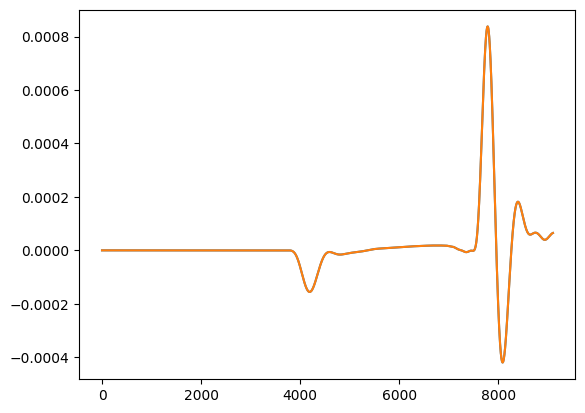

In [18]:
plt.plot(demphire_list[0].tensors_list[20][7]['Ux'][24])
plt.plot(demphire_list[1].tensors_list[20][7]['Ux'][24])

In [8]:
for i in range(len(demphire_list)):
    print(demphire_list[i].prefix)

lamb_demphire_R_0
lamb_demphire_R_01
lamb_demphire_R_001
lamb_demphire_R_0001
lamb_demphire_R_00001
lamb_demphire_R_000001


In [21]:
list(d.values())[0]

[1, 2, 3, 4, 5]

In [17]:
for x in d.values():
    print(x)

[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]


In [9]:
d = { 5 : [1, 2, 3, 4, 5],
      10 : [1, 2, 3, 4, 5]
}

In [36]:
conv_5freq = ConvergenceCheck(
    path=os.path.join('..', '..', 'exps', 'VasiliyTasks'),
    prefix="Task_1",
    cases_dict= { key: [3, 5] for key in [10] },
    verbose = True
)

10_3 uploaded
Найдена величина шага по времени 10 3: 4.12553269e-05
Найдено время работы солвера для 10 3: 1988
--------------------
10_5 uploaded
Найдена величина шага по времени 10 5: 1.75342941e-05
Найдено время работы солвера для 10 5: 8601
--------------------


In [39]:
for var, tensor in conv_5freq.tensors_list[10][3].items():
    print(var, tensor.shape)

Ux (71, 24240)
Uy (71, 24240)
Vx (71, 24240)
Vy (71, 24240)
Ax (71, 24240)
Ay (71, 24240)
S1 (71, 24240)
S2 (71, 24240)
P (71, 24240)


In [44]:
conv_5freq.tensors_list[10][3]['S2'].sum()

0.0

(24240,)
(57032,)


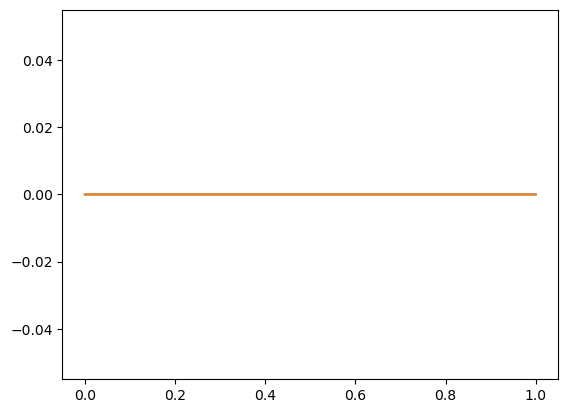

In [40]:
var = 'P'
reciever = 10
print(conv_5freq.tensors_list[10][3][var][reciever].shape)
print(conv_5freq.tensors_list[10][5][var][reciever].shape)
plt.plot(
    np.arange(conv_5freq.tensors_list[10][3][var].shape[-1]) / conv_5freq.tensors_list[10][3][var].shape[-1],
    conv_5freq.tensors_list[10][3][var][reciever]
)
plt.plot(
    np.arange(conv_5freq.tensors_list[10][5][var].shape[-1]) / conv_5freq.tensors_list[10][5][var].shape[-1],
    conv_5freq.tensors_list[10][5][var][reciever]
)

In [ ]:
b:\Elfimov\Dissertation\exps\Lamb_demphire_nodes\lamb_demphire_mass_0_R_01_20_7

In [33]:
demphire_list = []
prefix_list = [
    'lamb_demphire_mass_0_R_01',
    'lamb_demphire_mass_1_R_01',
    'lamb_demphire_mass_0_R_0',
    'lamb_demphire_0_R_01'
]

for prefix in prefix_list:
    demphire_list.append(ConvergenceCheck(
        path=os.path.join('..', '..', 'exps', 'Lamb_demphire_nodes'),
        prefix=prefix,
        cases_dict= { key: [7] for key in [20] },
        verbose = True
    ))
    # demphire.tensors_list[20][7].shape

20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3247
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 1233
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 828
--------------------
20_7 uploaded
Найдена величина шага по времени 20 7: 0.000329563348
Найдено время работы солвера для 20 7: 3294
--------------------


In [37]:
for var in ['Ux', 'Uy', 'Vx', 'Vy', 'Ax', 'Ay']:
    # for i in range(len(demphire_list)):
    for i in range(2):
        # print(f"Max i: {np.max(np.abs(demphire_list[i].tensors_list[20][7][var])):.3e}")
        # print(demphire_list[i].prefix, demphire_list[i].path)
        for j in range(i+1, len(demphire_list)):
            # print(f"Max j: {np.max(np.abs(demphire_list[j].tensors_list[20][7][var])):.3e}")
            if np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum() < 1e-12:
                a = 1
                # print('')
                # print(f"Совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")
            else:
                print(f"{var}: Не совпадение {i} и {j}, разница: {np.abs(demphire_list[i].tensors_list[20][7][var] - demphire_list[j].tensors_list[20][7][var]).sum():.3e}")

Ux: Не совпадение 0 и 1, разница: 1.586e+01
Ux: Не совпадение 0 и 2, разница: 1.187e-12
Ux: Не совпадение 1 и 2, разница: 1.586e+01
Ux: Не совпадение 1 и 3, разница: 1.586e+01
Uy: Не совпадение 0 и 1, разница: 3.117e+01
Uy: Не совпадение 1 и 2, разница: 3.117e+01
Uy: Не совпадение 1 и 3, разница: 3.117e+01
Vx: Не совпадение 0 и 1, разница: 4.113e+02
Vx: Не совпадение 0 и 2, разница: 3.347e-10
Vx: Не совпадение 0 и 3, разница: 2.148e-10
Vx: Не совпадение 1 и 2, разница: 4.113e+02
Vx: Не совпадение 1 и 3, разница: 4.113e+02
Vy: Не совпадение 0 и 1, разница: 6.001e+02
Vy: Не совпадение 0 и 2, разница: 1.650e-10
Vy: Не совпадение 0 и 3, разница: 4.391e-10
Vy: Не совпадение 1 и 2, разница: 6.001e+02
Vy: Не совпадение 1 и 3, разница: 6.001e+02
Ax: Не совпадение 0 и 1, разница: 1.410e+04
Ax: Не совпадение 0 и 2, разница: 1.878e-07
Ax: Не совпадение 0 и 3, разница: 1.914e-07
Ax: Не совпадение 1 и 2, разница: 1.410e+04
Ax: Не совпадение 1 и 3, разница: 1.410e+04
Ay: Не совпадение 0 и 1, разница

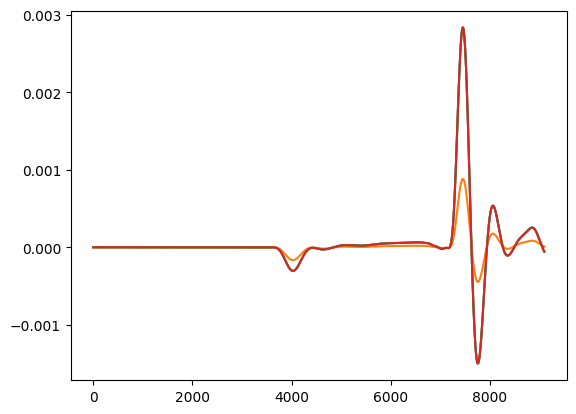

In [36]:
plt.plot(demphire_list[0].tensors_list[20][7]['Ux'][23])
plt.plot(demphire_list[1].tensors_list[20][7]['Ux'][23])
plt.plot(demphire_list[2].tensors_list[20][7]['Ux'][23])
plt.plot(demphire_list[3].tensors_list[20][7]['Ux'][23])